In [1]:
import torch
import numpy as np
import pandas as pd
import cv2
import scipy
import matplotlib.pyplot as plt


from data import preproc_a as preproc
from convert_to_onnx_original import RetinaStaticExportWrapper, RetinaStaticExportWrapperV2
from models.retinaface import UNetRetinaConcat
from data.custom_dataset import GroupeAlignedDetectionDataset
from IPython.display import clear_output

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
DATA_MODE = "groupe_aligned"
num_classes = 11
use_batch_normalization = True
bounding_box_from_points = False
multiclass = True
device = "cpu"

In [9]:
cfg = {"name": "mobilenet0.25",
       "pretrain": False,
       "return_layers": {"stage1": 1, "stage2": 2, "stage3": 3},
       "in_channel": 32,
       "out_channel": 64,
       "nms_threshold": 0.35,
       "confidence_threshold": -0.02,
       "image_size": 640,
       "top_k": 512,
       "min_sizes": [[16, 32], [64, 128], [256, 512]],
       "steps": [8, 16, 32],
       "variance": [0.1, 0.2],
       "clip": False,
       "mean": (0, 0, 0)}

img_dim = cfg["image_size"]
rgb_mean = cfg["mean"]

model = UNetRetinaConcat(cfg=cfg, use_batch_normalization=use_batch_normalization, num_classes=num_classes)
export_model = RetinaStaticExportWrapperV2(model, cfg, bounding_box_from_points, return_mask=True)

export_model.to(device)

RetinaStaticExportWrapperV2(
  (model): UNetRetinaConcat(
    (body): IntermediateLayerGetter(
      (stage1): Sequential(
        (0): Sequential(
          (0): Conv2d(6, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1, inplace=True)
          (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.1, inplace=True)
        )
        (2): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stri

In [10]:
optimizer = torch.optim.AdamW(export_model.parameters(), lr=0.001)

In [11]:
df_train = pd.read_csv("/home/ubuntu/projects/dataset/cvat/dataframe_year_digit_2025.02.15_fix.csv.zip")
df_validation = pd.read_csv("/home/ubuntu/projects/dataset/cvat_year/dataframe_year_digit_2025.03.10_fix.csv.zip")
_Dataset = GroupeAlignedDetectionDataset
transform_train = None

In [12]:
dataset_train = _Dataset(df_train, preproc(img_dim, rgb_mean, use_mirror=False, pre_scales=[1.0], transform=transform_train), multiclass=multiclass)

In [13]:
# Function to compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

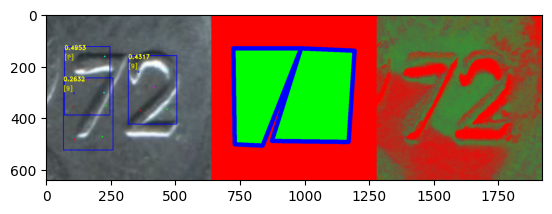

17 48 0.17030476375671819 1.6851747035980225 0.5701530575752258 0.584836567669129
17 49 0.15015451907095986 1.830199122428894 0.8789496421813965 0.5860119282762013
17 50 0.1702715473596873 2.9466500282287598 0.5248346924781799 0.7843415124385278
17 51 0.5334741491971746 2.424056053161621 0.3465940058231354 0.8326767627645904
17 52 0.23828734270636917 2.8987655639648438 0.34870702028274536 0.7619377532189058
17 53 0.21135685536328097 2.607696294784546 1.1497291326522827 0.674739152683935
17 54 0.055201274738979754 2.1292428970336914 0.7433253526687622 0.5937974177967504
17 55 0.21603363785118063 2.346735954284668 0.31421706080436707 0.8725580325810368


In [ ]:
for _j in range(1024):
    for _k in range(len(dataset_train)): 

        frame_data, mask_ground_truth, ground_truth = dataset_train[_k]
        mask_ground_truth = torch.tensor(mask_ground_truth)
        ground_truth = torch.tensor(ground_truth)
        ground_truth[:, :-1] = (ground_truth[:, :-1].reshape(ground_truth.shape[0], -1, 2) * \
                                torch.tensor(frame_data.shape[1:][::-1])).reshape(ground_truth[:, :-1].shape)
        output = export_model(torch.permute(frame_data[None, ...], (0, 2, 3, 1)).to(device))

        confidence_list, landmark_list, bbox_lsit, mask_predicted = \
            [item.detach().cpu().numpy() for item in output]

        frame_data = torch.permute(frame_data, (1, 2, 0)).contiguous().detach().byte().cpu().numpy()
        mask_ground_truth = (255 * torch.nn.functional.one_hot(mask_ground_truth.long()))[0].detach().cpu().numpy()
        mask_predicted = (255 * np.transpose(mask_predicted, (0, 2, 3, 1))[0]).astype(np.uint8)

        if _k % 16 == 0:
            for confidence, box, landmark in zip(confidence_list, bbox_lsit, landmark_list):
                label_index = int(confidence.argmax().item())
                label_confidence = confidence[label_index].item()
                label_show = int(max(label_index - 1, 0))

                _box = list(map(int, box + 0.5))
                _landm = list(map(int, landmark + 0.5))
                cv2.rectangle(frame_data, (_box[0], _box[1]), (_box[2], _box[3]), (0, 0, 255), 2)

                cx = _box[0]
                cy = _box[1] + 12
                text = f"{label_confidence:.4f}"
                cv2.putText(frame_data, text, (cx, cy),
                            cv2.FONT_HERSHEY_DUPLEX, 0.75, (255, 255, 0), thickness=2)

                cx = _box[0]
                cy = _box[1] + 48
                text = f"[{label_show}]"
                cv2.putText(frame_data, text, (cx, cy),
                            cv2.FONT_HERSHEY_DUPLEX, 0.75, (196, 196, 0), thickness=2)

                # landms
                cv2.circle(frame_data, (_landm[0], _landm[1]), 1, (0, 0, 255), 4)
                cv2.circle(frame_data, (_landm[2], _landm[3]), 1, (0, 255, 255), 4)
                cv2.circle(frame_data, (_landm[4], _landm[5]), 1, (255, 0, 255), 4)
                cv2.circle(frame_data, (_landm[6], _landm[7]), 1, (0, 255, 0), 4)
                cv2.circle(frame_data, (_landm[8], _landm[9]), 1, (255, 0, 0), 4)

            frame_show = np.hstack([frame_data, mask_ground_truth, mask_predicted])

            clear_output()
            plt.imshow(frame_show)
            plt.show()

        p_true = ground_truth[:, 4:14].reshape(-1, 1, 5, 2)
        p_pred = output[1].reshape(1, -1, 5, 2)

        loss_matrix = torch.square(p_true - p_pred).sum((-1, -2))

        cost_matrix = loss_matrix.detach()

        true_selection, pred_selection = scipy.optimize.linear_sum_assignment(cost_matrix)

        loss_class = torch.nn.functional.cross_entropy(output[0][pred_selection], ground_truth[:len(output[0]), -1].long())
        loss_points = loss_matrix[true_selection, pred_selection].mean() / (640 * 640)
        loss_negative_class = torch.nn.functional.cross_entropy(output[0], torch.zeros(len(output[0], ), dtype=torch.long), reduction='none')
        loss_negative_class[pred_selection] = 0 
        loss_negative_class = loss_negative_class.mean()
        loss_iou = 1 - sum([compute_iou(a, b) for a, b in zip(ground_truth[true_selection, 0:4], output[2][pred_selection, :])]) / len(ground_truth)

        loss = (loss_points + loss_class + loss_negative_class + loss_iou)

        if torch.isnan(loss):
            break

        if _k % 16 == 0:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = 0

        print(_j, _k, loss_points.item(), loss_class.item(), loss_negative_class.item(), loss_iou.item())

In [ ]:
ground_truth[:, 0:4]

tensor([[ 42.7046, 229.8453, 197.8240, 422.2462],
        [166.7457, 217.7535, 317.9252, 391.3984],
        [334.5228, 222.3430, 453.3876, 395.1287],
        [460.0098, 229.2377, 597.2953, 422.2464]], dtype=torch.float64)

In [ ]:
output[2].shape

torch.Size([0, 4])

In [ ]:
compute_iou

tensor(0., dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
    print(_k, loss_points.item(), loss_class.item(), loss_negative_class.item())

14 nan nan nan


In [ ]:
output[2].shape

torch.Size([512, 4])

In [ ]:
pred_selection.shape

In [ ]:
ground_truth.shape

In [ ]:
        # backprop
        optimizer.zero_grad()
        loss_l, loss_c, loss_landm = criterion(out, priors, targets)
        # loss_j = criterion_unet_b(mask_predicted, mask_true[:, 0, ...].long()) + criterion_unet_j(mask_predicted[:, 1:, ...], torch.clamp(mask_true.long() - 1, 0, 1))
        loss_j = criterion_unet_j(mask_predicted, mask_true.long())
        loss_b = criterion_unet_b(mask_predicted, mask_true[:, 0, ...].long())

        loss = cfg['loc_weight'] * loss_l + 10 * loss_c + loss_landm + weight_j * loss_j + weight_b * loss_b
        loss.backward()
        optimizer.step()


p_true = ground_truth[:, 4:14].reshape(-1, 1, 5, 2)
p_pred = output[1].reshape(1, -1, 5, 2)

loss_matrix = torch.square(p_true - p_pred).sum((-1, -2))

cost_matrix = -loss_matrix.detach()

true_selection, pred_selection = scipy.optimize.linear_sum_assignment(cost_matrix)

loss_points = loss_matrix[true_selection, pred_selection].mean() / 640


In [ ]:
loss_points

In [ ]:
p_true[true_selection] - p_pred[pred_selection]

In [ ]:
torch.take_along_dim(p_pred, torch.tensor(pred_selection), dim=0)

In [ ]:
pred_selection

In [ ]:
true_selection

In [ ]:
p_pred[pred_selection].shape

In [ ]:
landmark_list

In [ ]:
ground_truth

In [ ]:

    elif


        weight_j = 10
        weight_b = 10

        df_train = pd.read_csv("/home/ubuntu/projects/dataset/cvat/dataframe_year_digit_2025.02.15_fix.csv.zip")
        df_validation = pd.read_csv("/home/ubuntu/projects/dataset/cvat_year/dataframe_year_digit_2025.03.10_fix.csv.zip")
        _Dataset = GroupeAlignedDetectionDataset

    num_workers = multiprocessing.cpu_count()

    use_batch_normalization = True
    multiclass = num_classes > 2

    if use_batch_normalization:
        rgb_mean = (0, 0, 0)
    else:
        rgb_mean = (104, 117, 123) # bgr order

    save_folder = os.path.join(os.path.abspath(save_folder), '', DATA_MODE)

    cfg['pretrain'] = False
    max_epoch = 2048
    device = 'cpu'
    num_gpu = -1

    print("Printing net...")
    print(model)

In [ ]:
from __future__ import print_function
from collections import defaultdict
import multiprocessing
import os
from sklearn.metrics import precision_recall_fscore_support
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import torch.utils.data as data
from convert_to_onnx_original import RetinaStaticExportWrapper, RetinaStaticExportWrapperV2
from data import cfg_mnet, cfg_re50
from data import preproc_a as preproc
from data.custom_dataset import CustomDetectionDataset, GroupeAlignedDetectionDataset, GroupeDetectionDataset, GroupeAlignedMulticlassDetectionDataset
from layers.modules import MultiBoxLoss
from layers.functions.prior_box import PriorBox
import time
from datetime import datetime, timedelta
import math
import numpy as np
import pandas as pd
import cv2
import albumentations as A

from models.retinaface import UNetRetinaConcat
# from models.retinaface import RetinaFace
from segmentation_models_pytorch.losses.jaccard import JaccardLoss

DATA_MODE = 'single'
DATA_MODE = 'groupe'
DATA_MODE = 'groupe_aligned'
# DATA_MODE = 'groupe_multiclass'

class MetricMonitor:
    def __init__(self, name, float_precision=3):
        self.name = name
        self.float_precision = float_precision
        self.metrics = defaultdict(lambda: {"value": 0, "count": 0, "avg": 0})

    def update(self, metric_name, value, weight=1.):
        metric = self.metrics[metric_name]
        metric["value"] += value * weight
        metric["count"] += 1 * weight
        metric["avg"] = metric["value"] / (1e-7 + metric["count"])

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name,
                    avg=metric["avg"],
                    float_precision=self.float_precision) for (
                    metric_name,
                    metric) in self.metrics.items()])


def detection_collate(batch):
    """Custom collate fn for dealing with batches of images that have a different
    number of associated object annotations (bounding boxes).

    Arguments:
        batch: (tuple) A tuple of tensor images and lists of annotations

    Return:
        A tuple containing:
            1) (tensor) batch of images stacked on their 0 dim
            2) (list of tensors) annotations for a given image are stacked on 0 dim
    """
    targets = []
    frame_list = []
    mask_list = []
    for _, sample in enumerate(batch):
        frame_data, mask_data, target_data = sample
        frame_list.append(frame_data)
        targets.append(torch.from_numpy(target_data))
        mask_list.append(torch.from_numpy(mask_data))

        # import cv2
        # a = np.clip(np.transpose(128 + frame_data.cpu().detach().numpy(), (1, 2, 0)), 0, 256).astype(np.uint8)
        # print(target_data.shape)

    return torch.stack(frame_list, 0), torch.stack(mask_list, 0), targets


# Function to compute mAP
def compute_map(detections, annotations, iou_threshold=0.5):
    aps = []
    for det, ann in zip(detections, annotations):
        detected = [False] * len(det)
        true_positive = 0
        false_positive = 0
        for a in ann:
            matched = False
            for d in det:
                iou = compute_iou(d[:4], a)
                if iou >= iou_threshold:
                    true_positive += 1
                    matched = True
                    break
            if not matched:
                false_positive += 1
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / len(ann) if len(ann) > 0 else 0
        aps.append(precision * recall)

    return np.mean(aps)


# Function to compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

# Function to compute precision, recall, F1 score, and IoU
def compute_metrics(detections, annotations, iou_threshold=0.5):
    y_true = []
    y_pred = []

    for det, ann in zip(detections, annotations):
        detected = [False] * len(det)
        true_positive = 0
        false_positive = 0
        false_negative = len(ann)

        for a in ann:
            matched = False
            for d in det:
                iou = compute_iou(d[:4], a)
                if iou >= iou_threshold:
                    matched = True
                    break
            if matched:
                true_positive += 1
                false_negative -= 1
            else:
                false_positive += 1

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / len(ann) if len(ann) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        y_true.extend([1] * len(ann) + [0] * false_positive)
        y_pred.extend([1] * true_positive + [0] * (false_positive + false_negative))

    precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    return precision_avg, recall_avg, f1_score_avg


def validation_epoch(model, dataloader, device, visualiation_count=4):
    model.eval()
    torch.enable_grad(False)

    visualiation_frame_show_list = []

    annotations = []
    detections = []
    for item_batch in dataloader:
        for item in zip(*tuple(item_batch)):
            frame_data, mask_ground_truth, ground_truth = item
            ground_truth[:, :-1] = (ground_truth[:, :-1].reshape(ground_truth.shape[0], -1, 2) * \
                                    torch.tensor(frame_data.shape[1:][::-1])).reshape(ground_truth[:, :-1].shape)
            output = model(torch.permute(frame_data[None, ...], (0, 2, 3, 1)).to(device))
            confidence_list, landmark_list, bbox_lsit, mask_predicted = \
                [item.detach().cpu().numpy() for item in output]
            annotations.append(ground_truth[:, :4].detach().cpu().numpy())
            detections.append(bbox_lsit)

            if len(visualiation_frame_show_list) < visualiation_count:
                frame_data = torch.permute(frame_data, (1, 2, 0)).contiguous().detach().byte().cpu().numpy()
                mask_ground_truth = (255 * torch.nn.functional.one_hot(mask_ground_truth.long()))[0].detach().cpu().numpy()
                mask_predicted = (255 * np.transpose(mask_predicted, (0, 2, 3, 1))[0]).astype(np.uint8)

                for confidence, box, landmark in zip(confidence_list, bbox_lsit, landmark_list):
                    label_index = int(confidence.argmax().item())
                    label_confidence = confidence[label_index].item()
                    label_show = int(max(label_index - 1, 0))

                    _box = list(map(int, box + 0.5))
                    _landm = list(map(int, landmark + 0.5))
                    cv2.rectangle(frame_data, (_box[0], _box[1]), (_box[2], _box[3]), (0, 0, 255), 2)

                    cx = _box[0]
                    cy = _box[1] + 12
                    text = f"{label_confidence:.4f}"
                    cv2.putText(frame_data, text, (cx, cy),
                                cv2.FONT_HERSHEY_DUPLEX, 0.75, (255, 255, 0), thickness=2)

                    cx = _box[0]
                    cy = _box[1] + 48
                    text = f"[{label_show}]"
                    cv2.putText(frame_data, text, (cx, cy),
                                cv2.FONT_HERSHEY_DUPLEX, 0.75, (196, 196, 0), thickness=2)

                    # landms
                    cv2.circle(frame_data, (_landm[0], _landm[1]), 1, (0, 0, 255), 4)
                    cv2.circle(frame_data, (_landm[2], _landm[3]), 1, (0, 255, 255), 4)
                    cv2.circle(frame_data, (_landm[4], _landm[5]), 1, (255, 0, 255), 4)
                    cv2.circle(frame_data, (_landm[6], _landm[7]), 1, (0, 255, 0), 4)
                    cv2.circle(frame_data, (_landm[8], _landm[9]), 1, (255, 0, 0), 4)

                frame_show = np.vstack([frame_data, mask_ground_truth, mask_predicted])
                visualiation_frame_show_list.append(frame_show)

    frame_show = np.hstack(visualiation_frame_show_list)
    cv2.imwrite(F'frame_show_validation_{DATA_MODE}.jpg', frame_show)

    # Calculate mAP
    mAP = compute_map(detections, annotations)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

    # Calculate precision, recall, and F1 score
    precision, recall, f1_score = compute_metrics(detections, annotations)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    return mAP, precision, recall, f1_score


def train():
    parser = argparse.ArgumentParser(description='Retinaface Training')
    parser.add_argument('--training_dataset', default='./data/widerface/train/label.txt', help='Training dataset directory')
    parser.add_argument('--network', default='mobile0.25', help='Backbone network mobile0.25 or resnet50')
    parser.add_argument('--num_workers', default=4, type=int, help='Number of workers used in dataloading')
    parser.add_argument('--lr', '--learning-rate', default=1e-3, type=float, help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float, help='momentum')
    parser.add_argument('--resume_net', default=None, help='resume net for retraining')
    parser.add_argument('--resume_epoch', default=0, type=int, help='resume iter for retraining')
    parser.add_argument('--weight_decay', default=5e-4, type=float, help='Weight decay for SGD')
    parser.add_argument('--gamma', default=0.1, type=float, help='Gamma update for SGD')
    parser.add_argument('--save_folder', default='./weights/', help='Location to save checkpoint models')

    args = parser.parse_args()

    if not os.path.exists(args.save_folder):
        os.mkdir(args.save_folder)
    cfg = None
    if args.network == "mobile0.25":
        cfg = cfg_mnet
    elif args.network == "resnet50":
        cfg = cfg_re50

    # num_classes = 11
    # use_batch_normalization = True
    # multiclass = num_classes > 2

    img_dim = cfg['image_size']
    num_gpu = cfg['ngpu']
    batch_size = cfg['batch_size']
    max_epoch = cfg['epoch']
    gpu_train = cfg['gpu_train']

    batch_size = 8

    num_workers = args.num_workers
    momentum = args.momentum
    weight_decay = args.weight_decay
    initial_lr = args.lr
    gamma = args.gamma
    df_train = args.training_dataset
    save_folder = args.save_folder

    transform_train = A.Compose([
        A.OneOf([
            A.ImageCompression(compression_type='jpeg', quality_range=(50, 100), p=1.),
            A.ImageCompression(compression_type='webp', quality_range=(50, 100), p=1.),
        ], p=0.15),
        A.OneOf([
            A.Blur(blur_limit=3, p=1),
            A.MedianBlur(p=1),
            A.GridDistortion(p=1)
            ], p=0.15),
        A.OneOf([
            A.HueSaturationValue(p=1),
            A.RandomBrightnessContrast(p=1),
            A.RandomGamma(gamma_limit=(20, 180), p=1),
            A.ColorJitter(p=1)
            ], p=1.),
        A.OneOf([
            A.ToGray(p=1),
            A.ToSepia(p=1)
            ], p=0.15),
        A.OneOf([
            A.Affine(scale=(0.9, 1.1), rotate=(-180, 180), translate_percent=(0.025, 0.025), border=cv2.BORDER_REPLICATE, p=1.),
            A.Affine(scale=(0.9, 1.1), rotate=(-180, 180), translate_percent=(0.025, 0.025), border=cv2.BORDER_CONSTANT, cval=(0, 255), p=1.),
            ], p=0.9),
        A.Compose([
            A.OneOf([
                A.Resize(128, 128, p=1),
                A.Resize(196, 196, p=1),
                A.Resize(256, 256, p=1),
                A.Resize(384, 384, p=1),
                A.Resize(512, 512, p=1)], p=1),
            A.Resize(640, 640, p=1),
            ], p=0.25),
        ],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']),
        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False, angle_in_degrees=False,
                                         check_each_transform=False))

    transform_validation = None

    if DATA_MODE == 'single':
        df_train = pd.read_csv("/home/ubuntu/projects/dataset/cvat/dataframe_digit_2025.03.10.csv.zip")
        df_validation = pd.read_csv("/home/ubuntu/projects/dataset/cvat_year/dataframe_digit_2025.03.10.csv.zip")
        _Dataset = CustomDetectionDataset
    elif DATA_MODE == 'groupe':
        df_train = pd.read_csv("/home/ubuntu/projects/dataset/cvat/dataframe_year_digit_2025.02.15_fix.csv.zip")
        df_validation = pd.read_csv("/home/ubuntu/projects/dataset/cvat_year/dataframe_year_digit_2025_fix.03.10.csv.zip")
        _Dataset = GroupeDetectionDataset
    elif DATA_MODE == 'groupe_multiclass':
        num_classes = 1 + 3   # backgroud - 0, d4 - 1, d2 - 2, d1 - 3
        df_train = pd.read_csv("/home/ubuntu/projects/dataset/__ucoin_dataset_cache/df_year_region_detect_train_2025.04.12.csv.zip")
        df_validation = pd.read_csv("/home/ubuntu/projects/dataset/__ucoin_dataset_cache/df_year_region_detect_test_2025.04.12.csv.zip")
        _Dataset = GroupeAlignedMulticlassDetectionDataset

        weight_j = 20
        weight_b = 1

    elif DATA_MODE == "groupe_aligned":

        num_classes = 11
        weight_j = 10
        weight_b = 10

        df_train = pd.read_csv("/home/ubuntu/projects/dataset/cvat/dataframe_year_digit_2025.02.15_fix.csv.zip")
        df_validation = pd.read_csv("/home/ubuntu/projects/dataset/cvat_year/dataframe_year_digit_2025.03.10_fix.csv.zip")
        _Dataset = GroupeAlignedDetectionDataset

    num_workers = multiprocessing.cpu_count()

    use_batch_normalization = True
    multiclass = num_classes > 2

    if use_batch_normalization:
        rgb_mean = (0, 0, 0)
    else:
        rgb_mean = (104, 117, 123) # bgr order

    save_folder = os.path.join(os.path.abspath(save_folder), '', DATA_MODE)

    cfg['pretrain'] = False
    max_epoch = 2048
    device = 'cpu'
    num_gpu = -1

    model = UNetRetinaConcat(cfg=cfg, use_batch_normalization=use_batch_normalization, num_classes=num_classes)
    print("Printing net...")
    print(model)

    if args.resume_net is not None:
        model.load_state_dict(torch.load(args.resume_net))

    if num_gpu > 1 and gpu_train:
        model = torch.nn.DataParallel(model).to(device)
    else:
        model = model.to(device)
        
    config_name = cfg['name']
    export_config = {key: cfg[key] for key in ['variance']}
    export_config['nms_threshold'] = 0.35
    export_config['confidence_threshold'] = 0.02
    export_config['top_k'] = 512
    export_config['color_scheme'] = 'BGR'
    export_config['mean'] = rgb_mean

    bounding_box_from_points = False

    cudnn.benchmark = True

    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=32, threshold=1e-4,
                                                           factor=0.5, min_lr=1e-6, verbose=1)

    criterion_unet_j = JaccardLoss(mode='multiclass', from_logits=True, smooth=32)
    criterion_unet_b = torch.nn.CrossEntropyLoss()

    export_model = RetinaStaticExportWrapperV2(model, export_config, bounding_box_from_points, return_mask=True)
    export_model.to(device)

    model.train()
    epoch = 0 + args.resume_epoch
    print('Loading Dataset...')

    dataset_train = _Dataset(df_train, preproc(img_dim, rgb_mean, use_mirror=False, pre_scales=[1.0],
                                               transform=transform_train), multiclass=multiclass)

    dataset_validation = _Dataset(df_validation, preproc(img_dim, rgb_mean, use_mirror=False, pre_scales=[1.0],
                                                         transform=transform_validation), multiclass=multiclass)

    dataloader_train = DataLoader(dataset_train, batch_size=32,
                                  num_workers=num_workers, collate_fn=detection_collate)
    dataloader_validation = DataLoader(dataset_validation, batch_size=32, shuffle=True,
                                       num_workers=1, collate_fn=detection_collate)

    epoch_size = math.ceil(len(dataset_train) / batch_size)
    max_iter = max_epoch * epoch_size

    stepvalues = (cfg['decay1'] * epoch_size, cfg['decay2'] * epoch_size)
    step_index = 0

    if args.resume_epoch > 0:
        start_iter = args.resume_epoch * epoch_size
    else:
        start_iter = 0

    iteration = 0

    # for epoch in range(max_epoch):
    #     for i in range(len()):

    f1_score_max = -np.inf
    mode = 'Train'
    summary_writer_path = f'/home/ubuntu/projects/results/logs/detection-{DATA_MODE}-{config_name}/{datetime.now().isoformat()}'
    summary_writer = SummaryWriter(summary_writer_path)

    _datetime = datetime.now().isoformat()
    train_monitor = MetricMonitor('Train')

    for iteration in range(start_iter, max_iter):
        if iteration % epoch_size == 0:

            # create batch iterator
            batch_iterator = iter(data.DataLoader(dataset_train, batch_size, shuffle=True,
                                                  num_workers=num_workers, collate_fn=detection_collate))
            # if (epoch % 10 == 0 and epoch > 0) or (epoch % 5 == 0 and epoch > cfg['decay1']):
            #     torch.save(model.state_dict(), save_folder + '_epoch_' + str(epoch) + '.pth')
            epoch += 1

            mode = 'Train'
            for key, value in train_monitor.metrics.items():
                summary_writer.add_scalar(f'{mode}-{key}', value['avg'], iteration)

            train_monitor = MetricMonitor('Train')

            export_model.eval()
            model.eval()
            export_model.model.phase = 'test'
            mAP, precision, recall, f1_score = validation_epoch(export_model, dataloader_validation, device)
            export_model.model.phase = 'train'
            export_model.train()
            model.train()
            torch.enable_grad(False)

            if f1_score > f1_score_max:
                _best_model_path = os.path.join(save_folder, '', f'{config_name}_epoch_{str(epoch).zfill(4)}_mAP{mAP:.5f}_F1_{f1_score:.5f}.pth')
                os.makedirs(os.path.dirname(_best_model_path), exist_ok=True)
                print(f'Best Model :: {_best_model_path}')
                torch.save(model.state_dict(), _best_model_path)
                f1_score_max = f1_score

            mode = 'Validation'
            for key, value in zip(['mAP', 'precision', 'recall', 'f1_score'],
                                  [mAP, precision, recall, f1_score]):
                summary_writer.add_scalar(f'{mode}-{key}', value, iteration)

            lr = scheduler.optimizer.param_groups[0]['lr']
            summary_writer.add_scalar('LR', lr, iteration)

            scheduler.step(f1_score)

            _last_model_path = os.path.join(save_folder, '', f'{config_name}_{_datetime}_Final.pth')
            os.makedirs(os.path.dirname(_last_model_path), exist_ok=True)
            torch.save(model.state_dict(), _last_model_path)

        load_t0 = time.time()
        # if iteration in stepvalues:
        #     step_index += 1
        # lr = adjust_learning_rate(initial_lr, optimizer, gamma, epoch, step_index, iteration, epoch_size)

        # load train data
        images, mask_true, targets = next(batch_iterator)
        images = images.to(device)
        mask_true = mask_true.to(device)
        targets = [anno.to(device) for anno in targets]

        # forward
        out, mask_predicted = model(images)

        # backprop
        optimizer.zero_grad()
        loss_l, loss_c, loss_landm = criterion(out, priors, targets)
        # loss_j = criterion_unet_b(mask_predicted, mask_true[:, 0, ...].long()) + criterion_unet_j(mask_predicted[:, 1:, ...], torch.clamp(mask_true.long() - 1, 0, 1))
        loss_j = criterion_unet_j(mask_predicted, mask_true.long())
        loss_b = criterion_unet_b(mask_predicted, mask_true[:, 0, ...].long())

        loss = cfg['loc_weight'] * loss_l + 10 * loss_c + loss_landm + weight_j * loss_j + weight_b * loss_b
        loss.backward()
        optimizer.step()

        train_monitor.update("Landmarks", loss_landm.item())
        train_monitor.update("Confidence", loss_c.item())
        train_monitor.update("Location", loss_l.item())
        train_monitor.update("Jacard", loss_j.item())
        train_monitor.update("CCE", loss_b.item())

        if iteration % epoch_size == 0:
            item_count = 4
            # frame_data = np.transpose(images[0:item_count].detach().cpu().numpy(), (0, 2, 3, 1)) * 255 / (images.max() - images.min()).item()
            frame_data = (np.transpose(images[0:item_count].detach().cpu().numpy(), (0, 2, 3, 1)))
            mask_true_data = 255 * torch.nn.functional.one_hot(mask_true[0:item_count, 0].long().detach()).cpu().numpy()
            mask_predicted_data = 255 * np.transpose(torch.softmax(mask_predicted[0:item_count], dim=1).detach().cpu().numpy(), (0, 2, 3, 1))

            frame_show = np.vstack([np.hstack(frame_data), np.hstack(mask_true_data), np.hstack(mask_predicted_data)])
            cv2.imwrite(f'frame_show_{DATA_MODE}.jpg', frame_show)

        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        eta = int(batch_time * (max_iter - iteration))
        print('Epoch:{}/{} || Epochiter: {}/{} || Iter: {}/{} || Loc: {:.4f} Cla: {:.4f} Landm: {:.4f} Mask: {:.4f} || LR: {:.8f} || Batchtime: {:.4f} s || ETA: {}'
              .format(epoch, max_epoch, (iteration % epoch_size) + 1,
              epoch_size, iteration + 1, max_iter, loss_l.item(), loss_c.item(), loss_landm.item(), loss_j.item(), lr, batch_time, str(timedelta(seconds=eta))))


def adjust_learning_rate(initial_lr, optimizer, gamma, epoch, step_index, iteration, epoch_size):
    """Sets the learning rate
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    warmup_epoch = -1
    if epoch <= warmup_epoch:
        lr = 1e-6 + (initial_lr-1e-6) * iteration / (epoch_size * warmup_epoch)
    else:
        lr = initial_lr * (gamma ** (step_index))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

if __name__ == '__main__':
    train()
